# Problem Set #5

# Hyun Ki Kim

# 02/19/2018

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut, KFold
from pylab import rcParams
import statsmodels.api as sm
from scipy.interpolate import make_lsq_spline, BSpline
from scipy.interpolate import LSQUnivariateSpline

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Multinomial logistic regression and cross validation

# (a)

In [2]:
df = pd.read_csv("strongdrink.txt")
xvar = ["alco", "malic", "tot_phen", "color_int"]
X = df.loc[:, xvar]
y = df.loc[:, "cultivar"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

MultLogReg = LogisticRegression(multi_class="multinomial",
                                solver="newton-cg")
MultLogReg.fit(X_train, y_train)
y.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [3]:
coef = pd.DataFrame(MultLogReg.coef_[0:2], index = ["cultivar = 1", "cultivar = 2"], columns = xvar)
coef["Intercept"] = MultLogReg.intercept_[0:2]
coef

,alco,malic,tot_phen,color_int,Intercept
cultivar = 1,1.700369,-0.265602,1.223892,0.022762,-24.010559
cultivar = 2,-1.468065,-0.333055,0.664017,-0.922714,22.802711


In [4]:
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))
print("Error rates for j=1: 0.13, j=2: 0.0")

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

Error rates for j=1: 0.13, j=2: 0.0


Cultivar 3 has the least observation and the most accurated prediction (f1-score = 1.0).

# (b)

In [5]:
Xvars = df[xvar].values
yvals = df["cultivar"].values

N_loo = df.shape[0]

loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)

y_tests = np.zeros(N_loo)
y_preds = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class="multinomial",
                                solver="newton-cg")
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    
    y_tests[test_index] = y_test
    y_preds[test_index] = y_pred
    MSE_vec[test_index] = (y_test - y_pred) ** 2

print(classification_report(y_tests, y_preds))

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



Overall error rate has increased with excpetion for cultivar 1.

In [6]:
print("Average MSE:", MSE_vec.mean())

Average MSE: 0.0965909090909


# (c)

In [7]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
y_tests = np.array([])
y_preds = np.array([])

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class="multinomial",
                                solver="newton-cg")
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_tests = np.append(y_tests, y_test)
    y_preds = np.append(y_preds, y_pred)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    k_ind += 1

print(classification_report(y_tests, y_preds))

             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



Overall error rate for (c) is lower than those from (a) and (b).

In [8]:
print("Average MSE:", MSE_vec_kf.mean())

Average MSE: 0.107954545455


# 2. Splines and interpolation

# (a)

Text(0.5,1,'Scatter plot')

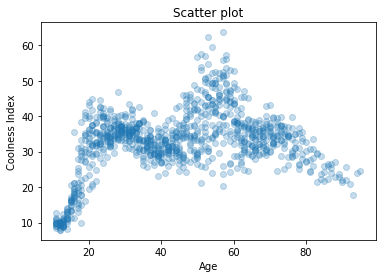

In [9]:
df = pd.read_csv("CoolIndex.txt",  names = ["age", "CI"])
x = np.array(df["age"])
y = np.array(df["CI"])

plt.scatter(x, y, alpha=0.25)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Scatter plot")

# (b)

In [10]:
CI = df["CI"]
age = df["age"]
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)

X_step = pd.DataFrame(dict(age_bin1 = age_bin1, age_bin2 = age_bin2,
                           age_bin3 = age_bin3, age_bin4 = age_bin4,
                           age_bin5 = age_bin5))
X_step.describe()

reg2 = sm.OLS(endog = CI, exog = X_step, missing="drop")
reg2_results = reg2.fit()

In [11]:
df.CI_stepwise = 0
df.loc[(df.age.astype(int) >= 11) & (df.age.astype(int) < 22), "CI_stepwise"] = reg2_results.params[0]
df.loc[(df.age.astype(int) >= 22) & (df.age.astype(int) < 40), "CI_stepwise"] = reg2_results.params[1]
df.loc[(df.age.astype(int) >= 40) & (df.age.astype(int) < 59), "CI_stepwise"] = reg2_results.params[2]
df.loc[(df.age.astype(int) >= 59) & (df.age.astype(int) < 77), "CI_stepwise"] = reg2_results.params[3]
df.loc[(df.age.astype(int) >= 77) & (df.age.astype(int) <=95), "CI_stepwise"] = reg2_results.params[4]

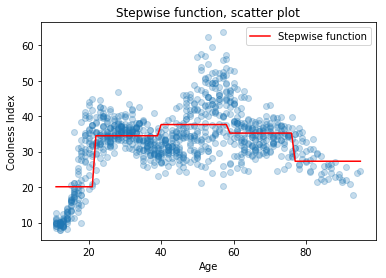

In [12]:
plt.scatter(x, y, alpha=0.25)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Stepwise function, scatter plot")
plt.plot(df["age"], df["CI_stepwise"], c = "red", label = "Stepwise function")
plt.legend()

In [13]:
print(reg2_results.summary())
print("The estimated step function values for each bin: 20.10, 34.48, 37.64, 35.23, 27.30")

                            OLS Regression Results                            
Dep. Variable:                     CI   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 19 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        10:48:10   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

In [14]:
print("Predicted coolness of a 73-year old from the stepwise function: 35.23")

Predicted coolness of a 73-year old from the stepwise function: 35.23


# (c)

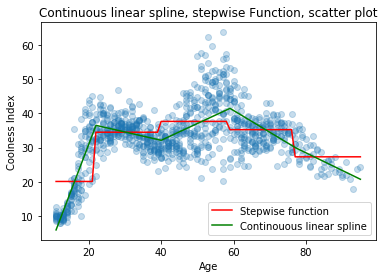

In [15]:
knots = [22, 40, 59, 77]
k = 1

spl_df = LSQUnivariateSpline(age.values, CI.values, knots, k=1)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.scatter(x, y, alpha=0.25)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Continuous linear spline, stepwise Function, scatter plot")
plt.plot(df["age"], df["CI_stepwise"], c = "red", label = "Stepwise function")
plt.plot(age_vec, spl_df(age_vec), c = "green", label = "Continouous linear spline")
plt.legend()

In [16]:
print("Predicted coolness of a 73-year old from the linear spline:", spl_df(np.array([73][0])))

Predicted coolness of a 73-year old from the linear spline: 32.536832389143306


# (d)

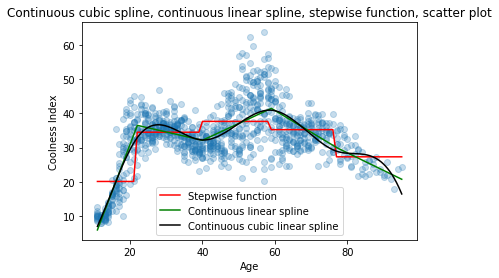

In [17]:
knots = [22, 40, 59, 77]
k = 1

cub_spl_df = LSQUnivariateSpline(age.values, CI.values, knots, k = 3)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.scatter(x, y, alpha=0.25)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Continuous cubic spline, continuous linear spline, stepwise function, scatter plot")
plt.plot(df["age"], df["CI_stepwise"], c = "red", label = "Stepwise function")
plt.plot(age_vec, spl_df(age_vec), c = "green", label = "Continuous linear spline")
plt.plot(age_vec, cub_spl_df(age_vec), c = "black", label = "Continuous cubic linear spline")
plt.legend()

In [18]:
print("Predicted coolness of a 73-year old from the cubic spline:", cub_spl_df(np.array([73][0])))

Predicted coolness of a 73-year old from the cubic spline: 31.262429389257864
